In [1]:
import numpy as np
import torch
import model2 as Model
import argparse
import core.logger as Logger
import core.metrics as Metrics
import os
import random
import scipy.io as scio
import matplotlib.pyplot as plt
import subprocess
import sys

# 添加解压 experiments.rar 的函数
def extract_experiments_rar():
    rar_file = "experiments.rar"
    
    # 检查 rar 文件是否存在
    if not os.path.exists(rar_file):
        print(f"警告: {rar_file} 不存在，跳过解压")
        return True
    
    # 检查是否已经解压过（检查目标文件夹是否存在）
    extract_dir = "experiments"
    if os.path.exists(extract_dir) and os.path.isdir(extract_dir):
        print(f"检测到 {extract_dir} 目录已存在，假设已解压，跳过解压")
        return True
    
    print("开始解压 experiments.rar...")
    
    try:
        # 方法1: 使用 unrar 命令（如果系统安装了 unrar）
        try:
            result = subprocess.run(['unrar', 'x', rar_file], 
                                  capture_output=True, text=True, check=True)
            print("使用 unrar 解压成功")
            return True
        except (subprocess.CalledProcessError, FileNotFoundError):
            pass
        
        # 方法2: 使用 7z 命令（如果系统安装了 p7zip）
        try:
            result = subprocess.run(['7z', 'x', rar_file], 
                                  capture_output=True, text=True, check=True)
            print("使用 7z 解压成功")
            return True
        except (subprocess.CalledProcessError, FileNotFoundError):
            pass
        
        # 方法3: 使用 Python 的 rarfile 库（需要安装）
        try:
            import rarfile
            with rarfile.RarFile(rar_file) as rf:
                rf.extractall()
            print("使用 rarfile 解压成功")
            return True
        except ImportError:
            print("未安装 rarfile 库，尝试其他方法...")
        except Exception as e:
            print(f"rarfile 解压失败: {e}")
        
        # 如果所有方法都失败，提示用户手动安装
        print("错误: 无法自动解压 experiments.rar")
        print("请手动安装解压工具:")
        print("1. Windows: 安装 WinRAR 或 7-Zip")
        print("2. Linux/Mac: 运行 'sudo apt-get install unrar' 或 'brew install unrar'")
        print("3. 或使用 pip install rarfile (需要安装 unrar 系统工具)")
        print("然后重新运行脚本")
        
        return False
        
    except Exception as e:
        print(f"解压过程中出现未知错误: {e}")
        return False

# 在脚本开始时执行解压
if not extract_experiments_rar():
    print("解压失败，程序退出")
    sys.exit(1)


警告: experiments.rar 不存在，跳过解压


export CUDA_VISIBLE_DEVICES=2
561
3
torch.Size([3, 256, 256])


sampling loop time step: 100%|██████████| 2000/2000 [00:51<00:00, 39.02it/s] 
/mnt/DATA1/guanxun/code/NUS_Diffusion-main_new/model2/model2.py:109: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/Copy.cpp:250.)
  out_dict['LR'] = self.data['LR'].detach().float().cpu()


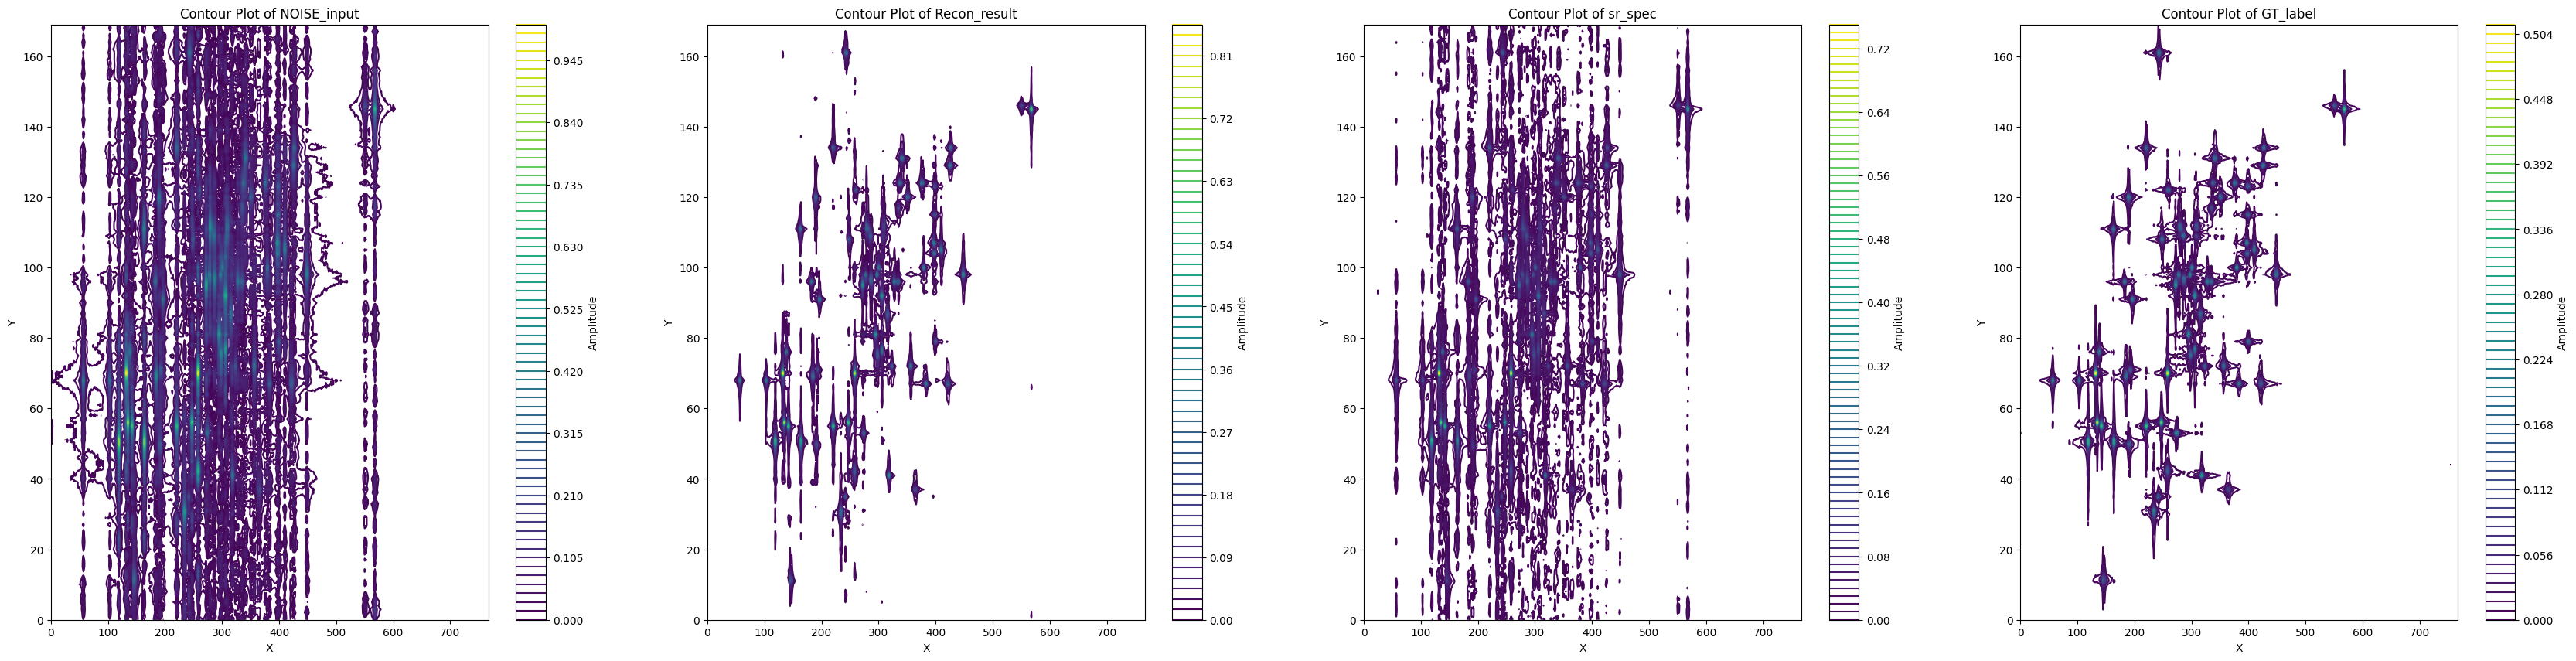

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='config/sr_sr3_256_256_val.json',
                        help='JSON file for configuration')
parser.add_argument('-p', '--phase', type=str, choices=['train', 'val'],
                        help='Run either train(training) or val(generation)', default='val')
parser.add_argument('-gpu', '--gpu_ids', type=str, default=None)
parser.add_argument('-debug', '-d', action='store_true')
parser.add_argument('-enable_wandb', action='store_true')
parser.add_argument('-log_wandb_ckpt', action='store_true')
parser.add_argument('-log_eval', action='store_true')

args = parser.parse_args(args=[])
opt = Logger.parse(args)
opt = Logger.dict_to_nonedict(opt)

# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def pad_data(data, block_size):
    # 获取数据的形状
    height, width = data.shape

    # 计算需要填充的行和列数
    pad_height = (block_size - height % block_size) % block_size
    pad_width = (block_size - width % block_size) % block_size

    # 在数据的底部和右侧填充0
    padded_data = np.pad(data, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

    return padded_data, pad_height, pad_width


def block_data(data, block_size):
    # 对数据进行填充
    padded_data, pad_height, pad_width = pad_data(data, block_size)

    # 获取填充后的数据的形状
    height, width = padded_data.shape

    # 计算水平和垂直方向上的块数
    num_blocks_vertical = height // block_size
    num_blocks_horizontal = width // block_size

    # 创建一个空数组来存储分块后的数据
    blocks = np.empty((num_blocks_vertical * num_blocks_horizontal, block_size, block_size), dtype=padded_data.dtype)

    # 分块
    idx = 0
    for i in range(num_blocks_vertical):
        for j in range(num_blocks_horizontal):
            block = padded_data[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
            blocks[idx] = block
            idx += 1

    return blocks, padded_data.shape, pad_height, pad_width


def reconstruct_data(blocks, pad_shape, pad_height, pad_width):
    # 获取填充后数据的形状
    height, width = pad_shape

    # 获取块的形状和数量
    num_blocks, block_height, block_width = blocks.shape

    # 计算水平和垂直方向上的块数
    num_blocks_vertical = height // block_height
    num_blocks_horizontal = width // block_width

    # 创建一个空数组来存储重构后的数据
    reconstructed_data = np.empty((height, width), dtype=blocks.dtype)

    # 重构数据
    idx = 0
    for i in range(num_blocks_vertical):
        for j in range(num_blocks_horizontal):
            block = blocks[idx]
            reconstructed_data[i * block_height:(i + 1) * block_height, j * block_width:(j + 1) * block_width] = block
            idx += 1

    # 删除填充的部分
    final_data = reconstructed_data[:height if not pad_height else -pad_height, :width if not pad_width else -pad_width]

    return final_data


data_path = f"{opt['datasets']['test']['real_data_path']}.mat"
sample_rate = opt['datasets']['test']['sample_rate']
ori_spec = scio.loadmat(data_path)['spec']
N1 = ori_spec.shape[0]
N2 = ori_spec.shape[1]

threshold = 0.01
mask = np.abs(ori_spec) < np.max(np.abs(ori_spec), axis=1, keepdims=True)[0] * threshold
# 使用掩码将原始张量中对应位置的值置为零
ori_spec[mask] = 0

phase_input, pad_shape, pad_height, pad_width = block_data(ori_spec, 256)
xx = np.fft.ifft(ori_spec, axis=0)

result_formatted = random.randint(1, 1000)  # 生成1到10000之间的随机整数
print(result_formatted)
Mask = scio.loadmat(f"./data/{sample_rate}_stack_mask-{N1}-{N2}/Mask_{result_formatted}.mat")['Mask']
U = Mask

NUS_FID = np.multiply(U, xx)
NOISE_input = np.fft.fft(NUS_FID, axis=0)
NUS_FID, _, _, _ = block_data(NUS_FID, 256)
NOISE_input, _, _, _ = block_data(NOISE_input, 256)

GT_label = np.fft.fft(xx, axis=0)
GT_label, _, _, _ = block_data(GT_label, 256)
block_num = phase_input.shape[0]
print(block_num)

max_amp = np.max(np.abs(NOISE_input))
NUS_FID = torch.complex(torch.from_numpy(NUS_FID.real).float(), torch.from_numpy(NUS_FID.imag).float()) / (
            max_amp * 3.5)
NOISE_input = torch.complex(torch.from_numpy(NOISE_input.real).float(), torch.from_numpy(NOISE_input.imag).float()) / (
    max_amp)
GT_label = torch.complex(torch.from_numpy(GT_label.real).float(), torch.from_numpy(GT_label.imag).float()) / (
            max_amp * 8)

LR = NUS_FID.unsqueeze(1)
SR = torch.cat((NOISE_input.real.unsqueeze(1), NOISE_input.imag.unsqueeze(1)), dim=1)
HR = torch.cat((GT_label.real.unsqueeze(1), GT_label.imag.unsqueeze(1)), dim=1)
print(GT_label.shape)
val_data = {'LR': LR, 'HR': HR, 'SR': SR}

diffusion = Model.create_model(opt)
avg_mse = 0.0
result_path = '{}/{}'.format(opt['path']['results'], 100)
os.makedirs(result_path, exist_ok=True)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')

val_data = diffusion.set_device(val_data)
diffusion.feed_data(val_data)
diffusion.test(continous=False)
visuals = diffusion.get_current_visuals()

try:
    if block_num is not None:
        fake_img = reconstruct_data(torch.complex(visuals['INF'][0 : block_num , 0], visuals['INF'][0 : block_num , 1]).float().cpu().numpy(), pad_shape, pad_height, pad_width)
        sr_img = reconstruct_data(torch.complex(visuals['SR'][-block_num : , 0], visuals['SR'][-block_num : , 1]).float().cpu().numpy(), pad_shape, pad_height, pad_width)
        sr_spec = reconstruct_data(torch.complex(visuals['SR_Spec'][-block_num : , 0], visuals['SR_Spec'][-block_num :, 1]).float().cpu().numpy(), pad_shape, pad_height, pad_width)
        hr_img = reconstruct_data(torch.complex(visuals['HR'][0 : block_num , 0], visuals['HR'][0 : block_num , 1]).float().cpu().numpy(), pad_shape, pad_height, pad_width)
        lr_img = reconstruct_data(visuals['LR'][0 : block_num].squeeze(1).float().cpu().numpy(), pad_shape, pad_height, pad_width)

except NameError:
    fake_img = torch.complex(visuals['INF'][0, 0], visuals['INF'][0, 1]).squeeze().float().cpu().numpy()
    sr_img = torch.complex(visuals['SR'][-1, 0], visuals['SR'][-1, 1]).squeeze().float().cpu().numpy()
    sr_spec = torch.complex(visuals['SR_Spec'][-1, 0], visuals['SR_Spec'][-1, 1]).squeeze().float().cpu().numpy()
    hr_img = torch.complex(visuals['HR'][0, 0], visuals['HR'][0, 1]).squeeze().float().cpu().numpy()
    lr_img = visuals['LR'][0].squeeze().float().cpu().numpy()

Metrics.save_contour2(
nus_spec=fake_img,
recon_spec=sr_img,
label_spec=hr_img,
sr_spec=sr_spec,  # result of densenet
save_path='{}/{}_{}_hr.png'.format(result_path, 200, 1))
plt.show()